In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# The GPU id to use, "0" to  "7"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
# Import Print function
from __future__ import print_function

In [3]:
# Add manual seed for deterministic results
import torch
torch.manual_seed(1)

# Set Constant Values
batch_size = 64
ricap_beta = 0.4
class_map = {
    'PLANE': 0,
    'CAR': 1,
    'BIRD': 2,
    'CAT': 3,
    'DEER': 4,
    'DOG': 5,
    'FROG': 6,
    'HORSE': 7,
    'SHIP': 8,
    'TRUCK': 9
}

# Enable or disable visualizations
show_summary = True
show_dataset_analyze = True

In [4]:
from woolly.utils import get_device

# Check GPU availability
use_cuda, device = get_device()

In [5]:
# Load test and train loaders
from woolly.dataset import get_cifar_loader, get_advance_cifar_loader
# Get transforme functions
from woolly.transform import BASE_PROFILE, get_transform

import json

train_profile = {
    'normalize': BASE_PROFILE['normalize'],
    'shift_scale_rotate': BASE_PROFILE['shift_scale_rotate'],
    'pad_and_crop': BASE_PROFILE['pad_and_crop'],
#     'crop_and_pad': BASE_PROFILE['crop_and_pad'],
    'random_brightness_contrast': BASE_PROFILE['random_brightness_contrast'],
    'horizontal_flip': BASE_PROFILE['horizontal_flip'],
    'to_gray': BASE_PROFILE['to_gray'],
    'coarse_dropout': BASE_PROFILE['coarse_dropout'],
    'to_tensor':  BASE_PROFILE['to_tensor'],
}

train_profile['pad_and_crop']['pad'] = 4
train_profile['pad_and_crop']['p'] = 0.5

train_profile['coarse_dropout']['min_height'] = 16
train_profile['coarse_dropout']['min_width'] = 16

normalize = {
    'normalize': BASE_PROFILE['normalize'],
    'to_tensor':  BASE_PROFILE['to_tensor'],
}

course_dropout = {
    'coarse_dropout': BASE_PROFILE['coarse_dropout'],
}

ricap_profile = {
    'p': 0.3,
    'ricap_beta': ricap_beta
}

# course_dropout['coarse_dropout']['min_height'] = 8
# course_dropout['coarse_dropout']['min_width'] = 8

print('Train Profile:', json.dumps(train_profile, indent = 4))
print('Normalize Profile:', json.dumps(normalize, indent = 4))
print('Course Dropout Profile:', json.dumps(course_dropout, indent = 4))
print('Ricap Profile:', json.dumps(ricap_profile, indent = 4))

# # create train and test loaders with transforms
# train_loader, test_loader = get_advance_cifar_loader(
#     base_transform=get_transform(train_profile),
#     normalize=get_transform(normalize),
# #     apply_ricap=ricap_profile,
# #     apply_cutout=get_transform(course_dropout),
#     batch_size=batch_size, 
#     use_cuda=use_cuda
# )

train_loader, test_loader = get_cifar_loader(get_transform(train_profile), get_transform(normalize), batch_size=batch_size, use_cuda=use_cuda)

Train Profile: {
    "normalize": {
        "mean": [
            0.4914,
            0.4822,
            0.4465
        ],
        "std": [
            0.247,
            0.2435,
            0.2616
        ]
    },
    "shift_scale_rotate": {
        "shift_limit": 0.15,
        "scale_limit": 0.15,
        "rotate_limit": 10,
        "p": 0.3
    },
    "pad_and_crop": {
        "height": 32,
        "width": 32,
        "pad": 4,
        "fill": [
            0.4914,
            0.4822,
            0.4465
        ],
        "p": 0.5
    },
    "random_brightness_contrast": {
        "p": 0.3
    },
    "horizontal_flip": {
        "p": 0.3
    },
    "to_gray": {
        "p": 0.3
    },
    "coarse_dropout": {
        "max_holes": 1,
        "max_height": 16,
        "max_width": 16,
        "min_holes": 1,
        "min_height": 16,
        "min_width": 16,
        "fill_value": [
            0.4914,
            0.4822,
            0.4465
        ],
        "p": 0.3
    },
    "to_t

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

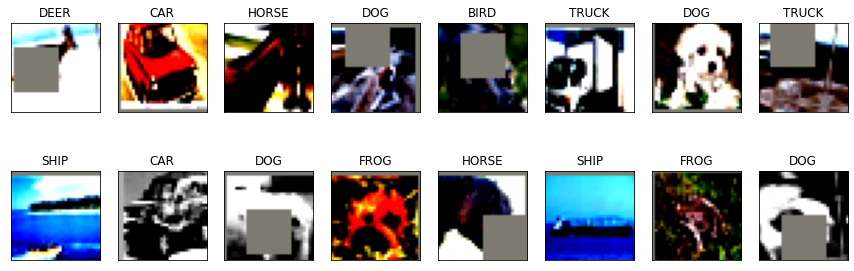

In [6]:
# We will now visualize DataSet by printing data scale and some samples
from woolly.visualize import print_class_scale, print_samples, print_samples_native
if show_dataset_analyze:
    # print class scale
#     print_class_scale(train_loader, class_map)
    # print data samples
#     print_samples_native(train_loader, class_map)
    print_samples(train_loader, class_map)

## Load and Train Network

1. Here we will first set all hyper parameters
2. Create moidel instance
3. Print Model summary
4. Run training for all three model techniques

In [ ]:
from woolly.model import WyCifar10Net
from woolly.backpropagation import train, train_ricap, train_native, test, test_native, get_sgd_optimizer, get_adam_optimizer, get_crossentropy_criteria
from woolly.utils import initialize_weights, print_modal_summary, print_summary
from woolly.scheduler import one_cycle_lr_pt, one_cycle_lr_custom
from woolly.training import Training

# Set Hyper Parameters Train Params
epochs = 30
lr = 0.05
max_lr = 0.5
steps_per_epoch = len(train_loader)
dropout = False
drop_ratio = 0.1
use_l1 = False
lambda_l1 = 1e-7
momentum = 0.9
weight_decay = 0.000125
weight_decay = weight_decay/batch_size

print("Using Device:", device)
print("Epochs:", epochs)
print("Lr:", lr)
print("Max Lr:", max_lr)
print("Batch Size:", batch_size)
print("Dropout:", dropout)
print("Dropout Ratio:", drop_ratio)
print("Momentum:", momentum)
print("Weight Decay:", weight_decay)
print("Use L1:", use_l1)
print("L1 Lambda:", lambda_l1)
print("RICAP Beta", ricap_beta)


# Batch Normalization Technique to be used
norm='bn'
use1x1=True
ctype='depthwise_seperable'
base_channels=16
repetations=1
usedilation=False
use_skip=False
train_function=train
test_function=test

# Create an instance of train function which uses ricap augumented images
ctrain = train_function(use_l1=use_l1, lambda_l1=lambda_l1)

# Create model instance based on parameter which one to use
model = WyCifar10Net(
    image=(32, 32), 
    ctype=ctype, 
    use1x1=use1x1, 
    base_channels=base_channels, 
    layers=repetations, 
    drop_ratio=drop_ratio, 
    usedilation=usedilation, 
    use_skip=use_skip
).apply(initialize_weights).to(device)

# Create optimizer instance based on hyper parameters
optimizer = get_sgd_optimizer(model, lr=lr, momentum=momentum, weight_decay=weight_decay)
criteria = get_crossentropy_criteria(device)

# Create Pytorch One Cycle scheduler instance
# pytorch_scheduler = one_cycle_lr_pt(
#     optimizer, 
#     lr=lr, 
#     max_lr=max_lr, 
#     steps_per_epoch=steps_per_epoch, 
#     epochs=epochs, 
#     anneal_strategy='linear'
# )

import numpy as np
schedule = np.interp(np.arange(epochs+1), [0, 7, epochs], [lr, max_lr, lr/20.0])

# Create Custom One Cycle schedule instance
custom_scheduler = one_cycle_lr_custom(
    optimizer, 
    lr=lr, 
    max_lr=max_lr, 
    steps_per_epoch=steps_per_epoch, 
    epochs=epochs,
    schedule=schedule
)

# Create instance of trainer with all params
trainer = Training(
    model,
    optimizer,
    criteria,
    custom_scheduler,
    ctrain,
    test_function,
    train_loader,
    test_loader,
    lr,
    epochs,
    device,
    dropout
)

if show_summary:
    print_summary(model, input_size=(3, 32, 32))
#     print_modal_summary(trainer.model)
# Run trainer
trainer.run()

Using Device: cuda
Epochs: 30
Lr: 0.05
Max Lr: 0.5
Batch Size: 64
Dropout: False
Dropout Ratio: 0.1
Momentum: 0.9
Weight Decay: 1.953125e-06
Use L1: False
L1 Lambda: 1e-07
RICAP Beta 0.4
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
          WyConv2d-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
            Conv2d-4           [-1, 32, 32, 32]           9,216
          WyConv2d-5           [-1, 32, 32, 32]               0
       BatchNorm2d-6           [-1, 32, 32, 32]              64
        WyResidual-7           [-1, 32, 32, 32]               0
            Conv2d-8           [-1, 32, 16, 16]             288
            Conv2d-9           [-1, 64, 16, 16]           2,048
         WyConv2d-10           [-1, 64, 16, 16]               0
      BatchNorm2d-11           [-1, 64, 16, 

## Grad Cam

Here we will implement gradcoam on different images

In [ ]:
from woolly.gradcam.compute import compute_gradcam

compute_gradcam(model, class_map, path='./data', device=device)

## Analyze Network

We will print comparison between train and test accuries and incorrect predictions

In [ ]:
# Visualize network performance

from woolly.visualize import plot_network_performance
from woolly.utils import get_incorrrect_predictions
from woolly.visualize import plot_incorrect_predictions

from woolly.utils import get_all_predictions, get_incorrrect_predictions, prepare_confusion_matrix
from woolly.visualize import plot_confusion_matrix


#     trainer.print_best_model()
plot_network_performance(epochs, trainer.schedule, trainer.list_train_loss, trainer.list_valid_loss, trainer.list_train_correct, trainer.list_valid_correct)

all_preds, all_targets = get_all_predictions(trainer.model, test_loader, device)
confusion_matrix = prepare_confusion_matrix(all_preds, all_targets, class_map)
plot_confusion_matrix(confusion_matrix, class_map, False)

incorrect = get_incorrrect_predictions(trainer.model, test_loader, device)
plot_incorrect_predictions(incorrect, class_map)